# CellPhenoX simulation analysis - interactions

## Here, we simulate the case where converter status is dependent upon, or *interacts* with, time ("visit"). At time point V0 we see that converters and non-converters have the same proportions of each cell type, major and minor. At time point V1, non-converters have a higher proportion of celltypes A and I compared to converters, while converters have a higher proportion of celltypes B and J compared to non-converters. Code from Dr. Jun Inamo.

In [ ]:
source("./simulation_functions.R")

## 1. First Situation

In [136]:
n_cells=100 # cells per individual
sd_celltypes=0.1  # standard deviation of number of cells 
n_major_cell_types=7
n_minor_cell_types=3
relative_abundance=0.4 # ratio between major and rare
n_major_interact_celltypes=2
n_minor_interact_celltypes=2
n_individuals=30 # total individuals
n_batchs=4
prop_sex=0.5 # proportion of feature 1 if feature 1 is categorical variable
prop_disease=0.5  # proportion of feature 2 if feature 2 is categorical variable
interaction_feature="sex" #"visit"
test_var="condition_val"
time_points = 2

# difference in proportion of cells 
# proportion of interacted cells which are from people with interacted group
fc_interact=0.6 #0.3 
# specific, hardest scenario, significant difference in cell proportions for just one time point (V1)
# differential, scenario, significant difference in cell proportions for both time points
# opposite, simplest scenario, difference in cell proportions is low in one time point and high in the other
interaction_type="opposite" # c("specific","differential","opposite")
seed=1234

n_pcs = 20
cluster_pcs = 1:20
disease_pcs = 0
sex_pcs = 0 # seq(2, 20, by = 2)
age_pcs = 0 # seq(2, 10, by = 2)
bmi_pcs = 0 # seq(11, 20, by = 2)
batch_pcs = 0 # seq(1, 20,by = 2)
interaction_pcs = 0
visit_pcs = 0
subject_pcs = 0
# Define the maximum variance of each attribute
cluster_ratio = 0.8
disease_ratio = 0
sex_ratio = 0 # 0.05
age_ratio = 0 # 0.05
bmi_ratio = 0 # 0.05
batch_ratio = 0 # 0.1
visit_ratio = 0
interaction_ratio = 0
subject_ratio = 0

scale_factor = 5

cluster_col = "cell_type"
sex_col = "sex"
age_col = "age"
bmi_col = "bmi"
batch_col = "batch"
disease_col = "disease"
visit_col = "visit"
samplem_key = 'sample_id'

# parameters for UMAP
n_neighbors = 30
metric = "cosine"
min_dist = 0.01

# parameters for CNA
test_var="condition_val"
samplem_key = 'subject_id'
graph_use = 'RNA_nn'
batches = "batch"

nsteps = NULL
verbose=TRUE
assay=NULL
key='NAMPC_'
maxnsteps=15L
max_frac_pcs=0.15
ks=NULL
Nnull=1000
force_permute_all=FALSE
local_test=TRUE
return_nam=TRUE

### 1.1 Generating dummy data

In [138]:
dummy_data = generate_dummy_data_time(n_cells = n_cells, # cells of major cell types per individual
                                      sd_celltypes = sd_celltypes,  # standard deviation of number of cells 
                                      n_major_cell_types = n_major_cell_types,
                                      n_minor_cell_types = n_minor_cell_types,
                                      relative_abundance = relative_abundance, # ratio between major and rare
                                      n_major_interact_celltypes = n_major_interact_celltypes,
                                      n_minor_interact_celltypes = n_minor_interact_celltypes,
                                      
                                      n_individuals = n_individuals, # total individuals
                                      n_batchs = n_batchs,
                                      
                                      interaction_feature = interaction_feature,
                                      time_points = time_points,
                                      
                                      test_var = disease_col,
                                      prop_disease = prop_disease,  
                                      
                                      fc_interact = fc_interact, # additional proportion of interacted cells which are from people with interacted group compared to non-interacted cell types
                                      interaction_type = interaction_type,
                                      seed = seed)
interact_cell_types = dummy_data[[2]]
dummy_data = dummy_data[[1]]

interact_cell_types
head(dummy_data)

  subject_id sample_id visit sex disease age batch bmi interaction
1      SUB_1  SUB_1_V0     0   0       1  31     1  29 sex:disease
2      SUB_2  SUB_2_V0     0   0       0  51     2  30 sex:disease
3      SUB_3  SUB_3_V0     0   0       0  57     3  16 sex:disease
4      SUB_4  SUB_4_V0     0   1       1  18     4  27 sex:disease
5      SUB_5  SUB_5_V0     0   1       1  43     1  20 sex:disease
6      SUB_6  SUB_6_V0     0   0       1  55     2  27 sex:disease
  subject_id sample_id visit sex disease age batch bmi interaction
1      SUB_1  SUB_1_V0     0   0       1  31     1  29 sex:disease
2      SUB_2  SUB_2_V0     0   0       0  51     2  30 sex:disease
3      SUB_3  SUB_3_V0     0   0       0  57     3  16 sex:disease
4      SUB_4  SUB_4_V0     0   1       1  18     4  27 sex:disease
5      SUB_5  SUB_5_V0     0   1       1  43     1  20 sex:disease
6      SUB_6  SUB_6_V0     0   0       1  55     2  27 sex:disease
  interact_term
1             0
2             0
3             

[1] "A" "B" "I" "J"

,sample_id,subject_id,visit,sex,disease,age,batch,bmi,interaction,interact_term,cell_type
,<chr>,<chr>,<int>,<int>,<fct>,<int>,<fct>,<int>,<chr>,<int>,<chr>
2214,SUB_11_V0,SUB_11,0,0,1,31,3,16,sex:disease,0,J
39595,SUB_4_V0,SUB_4,0,1,1,18,4,27,sex:disease,2,I
20642,SUB_21_V1,SUB_21,1,1,1,37,1,28,sex:disease,2,B
22196,SUB_22_V1,SUB_22,1,0,1,22,2,35,sex:disease,0,C
33120,SUB_29_V0,SUB_29,0,0,0,46,1,22,sex:disease,0,E
2288,SUB_11_V0,SUB_11,0,0,1,31,3,16,sex:disease,0,A


In [139]:
pcs_matrix = generate_pseudo_pcs_time(dummy_data, 
                                             n_pcs = n_pcs, 
                                             cluster_pcs = cluster_pcs,
                                             disease_pcs = disease_pcs,
                                             sex_pcs = sex_pcs, 
                                             age_pcs = age_pcs,
                                             bmi_pcs = bmi_pcs,
                                             batch_pcs = batch_pcs,
                                             interaction_pcs = interaction_pcs,
                                             visit_pcs = visit_pcs,
                                             subject_pcs = subject_pcs,
                                             
                                             # 各属性の割合の最大値を定義
                                             cluster_ratio = cluster_ratio,
                                             disease_ratio = disease_ratio,
                                             sex_ratio = sex_ratio,
                                             age_ratio = age_ratio,
                                             bmi_ratio = bmi_ratio,
                                             batch_ratio = batch_ratio,
                                             interaction_ratio = interaction_ratio,
                                             visit_ratio = visit_ratio,
                                             subject_ratio = subject_ratio,
                                             
                                             scale_factor = scale_factor,
                                             
                                             cluster_col = cluster_col,
                                             sex_col = sex_col,
                                             age_col = age_col,
                                             bmi_col = bmi_col,
                                             batch_col = batch_col,
                                             disease_col = disease_col,
                                             visit_col = visit_col,
                                             seed = seed
                                             # interact_term_col = "interact_term"
)
colnames(pcs_matrix) <- paste0("PC", 1:ncol(pcs_matrix))

umap_res <- uwot::umap(pcs_matrix, 
                       n_neighbors = n_neighbors, 
                       metric = "cosine", 
                       min_dist = min_dist)
umap_res = umap_res %>% 
  magrittr::set_colnames(c("UMAP1","UMAP2")) %>%
  as.data.frame()

In [140]:
head(pcs_matrix)

PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
-0.9345181,-0.2261286,-0.73427268,-0.29949486,-0.33660852,0.21522206,-0.03847079,-0.07759120,-0.08603162,-0.07736487,0.03488986,0.18987254,-0.0571488015,-0.12859690,-0.02657828,-0.08322772,-0.30244189,-4.699002e-02,-0.10290527,0.129458735
0.7240982,0.2598460,0.05510367,0.09463313,0.24796017,-0.04735008,0.43283133,0.04010209,-0.20411393,0.06670420,0.14085783,-0.03250477,0.2066263802,-0.15246522,0.07609024,-0.07497060,0.17176028,-7.129145e-02,0.03034914,-0.100452683
-0.9473605,0.3978922,-0.58192185,-0.10677953,0.02891341,0.19056757,-0.09188119,-0.05801173,-0.32306751,-0.01104646,-0.15587860,0.26764396,-0.0482663712,0.13977225,0.02912187,-0.15766090,-0.17557096,-1.322441e-01,-0.10472262,-0.097967168
-1.4278789,0.1985055,-0.25273345,-0.03041582,0.15866765,-0.11076530,0.21202813,-0.04167103,0.16292988,0.07648328,0.11629409,-0.31436890,0.0008515355,-0.01105390,-0.01180227,-0.25131944,0.18948051,1.624027e-05,-0.04342528,0.003747438
0.9030164,-0.3575601,-0.36077965,0.09498022,-0.16137370,-0.25875136,0.41268067,-0.20160264,-0.12266172,0.01650566,-0.03650752,-0.05472022,0.1814448750,-0.01089786,-0.05434061,-0.13111978,-0.07170570,-2.530846e-02,0.01839925,-0.021188726
-1.0940373,-0.1219208,-0.04572330,-0.46452822,0.37035415,-0.13143382,0.01605878,-0.06469616,-0.08795619,-0.10435344,-0.05860343,0.08426160,0.0294042910,-0.11124889,0.12634602,-0.01924675,-0.06117857,-1.332889e-01,0.04486747,0.131836936


### 1.2 Mixed effect model

In [141]:
masc_df = dummy_data
masc_df$subject_id = factor(masc_df$subject_id)
masc_df$sample_id = factor(masc_df$sample_id)

masc = GLM_interact(dataset = masc_df,
                    cluster = masc_df$cell_type,
                    contrast1 = interaction_feature,
                    contrast2 = disease_col,
                    random_effects = samplem_key,
                    fixed_effects = NULL,
                    verbose = TRUE, save_models = FALSE)
masc

Using null model: cluster ~ (1|subject_id) + sex + disease

Using full model: cluster ~ (1|subject_id) + sex + disease + sex:disease

Creating logistic mixed models for clusterA

boundary (singular) fit: see help('isSingular')

Creating logistic mixed models for clusterB

boundary (singular) fit: see help('isSingular')

Creating logistic mixed models for clusterC

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

Creating logistic mixed models for clusterD

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

Creating logistic mixed models for clusterE

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

Creating logistic mixed models for clusterF

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

Creating logistic mixed models for clusterG

boundary (singular) fit: see help('isSingular')

boundary (si

,cluster,size,model.pvalue,sex:disease1.OR,sex:disease1.OR.95pct.ci.lower,sex:disease1.OR.95pct.ci.upper
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
clusterA,clusterA,6147,4.630668e-27,0.2249853,0.1993823,0.2538761
clusterB,clusterB,5936,8.012672e-27,5.1512422,4.5650596,5.8126943
clusterC,clusterC,6073,6.739993e-01,0.9771451,0.8773456,1.0882970
clusterD,clusterD,5927,5.976184e-01,0.9711093,0.8707002,1.0830975
clusterE,clusterE,5901,6.533219e-01,1.0252973,0.9193734,1.1434251
clusterF,clusterF,5957,8.235411e-01,0.9877189,0.8860446,1.1010603
clusterG,clusterG,6009,7.971830e-01,0.9859127,0.8848982,1.0984585
clusterH,clusterH,2384,9.273563e-01,0.9923539,0.8419942,1.1695642
clusterI,clusterI,2439,1.538645e-22,0.2096015,0.1730353,0.2538949


### 1.3 Visualization

`summarise()` has grouped output by 'subject_id', 'sex', 'disease'. You can
override using the `.groups` argument.
Warning message:
"`funs()` was deprecated in dplyr 0.8.0.
i Please use a list of either functions or lambdas:

# Simple named list: list(mean = mean, median = median)

# Auto named with `tibble::lst()`: tibble::lst(mean, median)

# Using lambdas list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))"
Warning message in wilcox.test.default(c(4.63576158940397, 5.04866180048662, 4.94203782794387, :
"cannot compute exact p-value with ties"


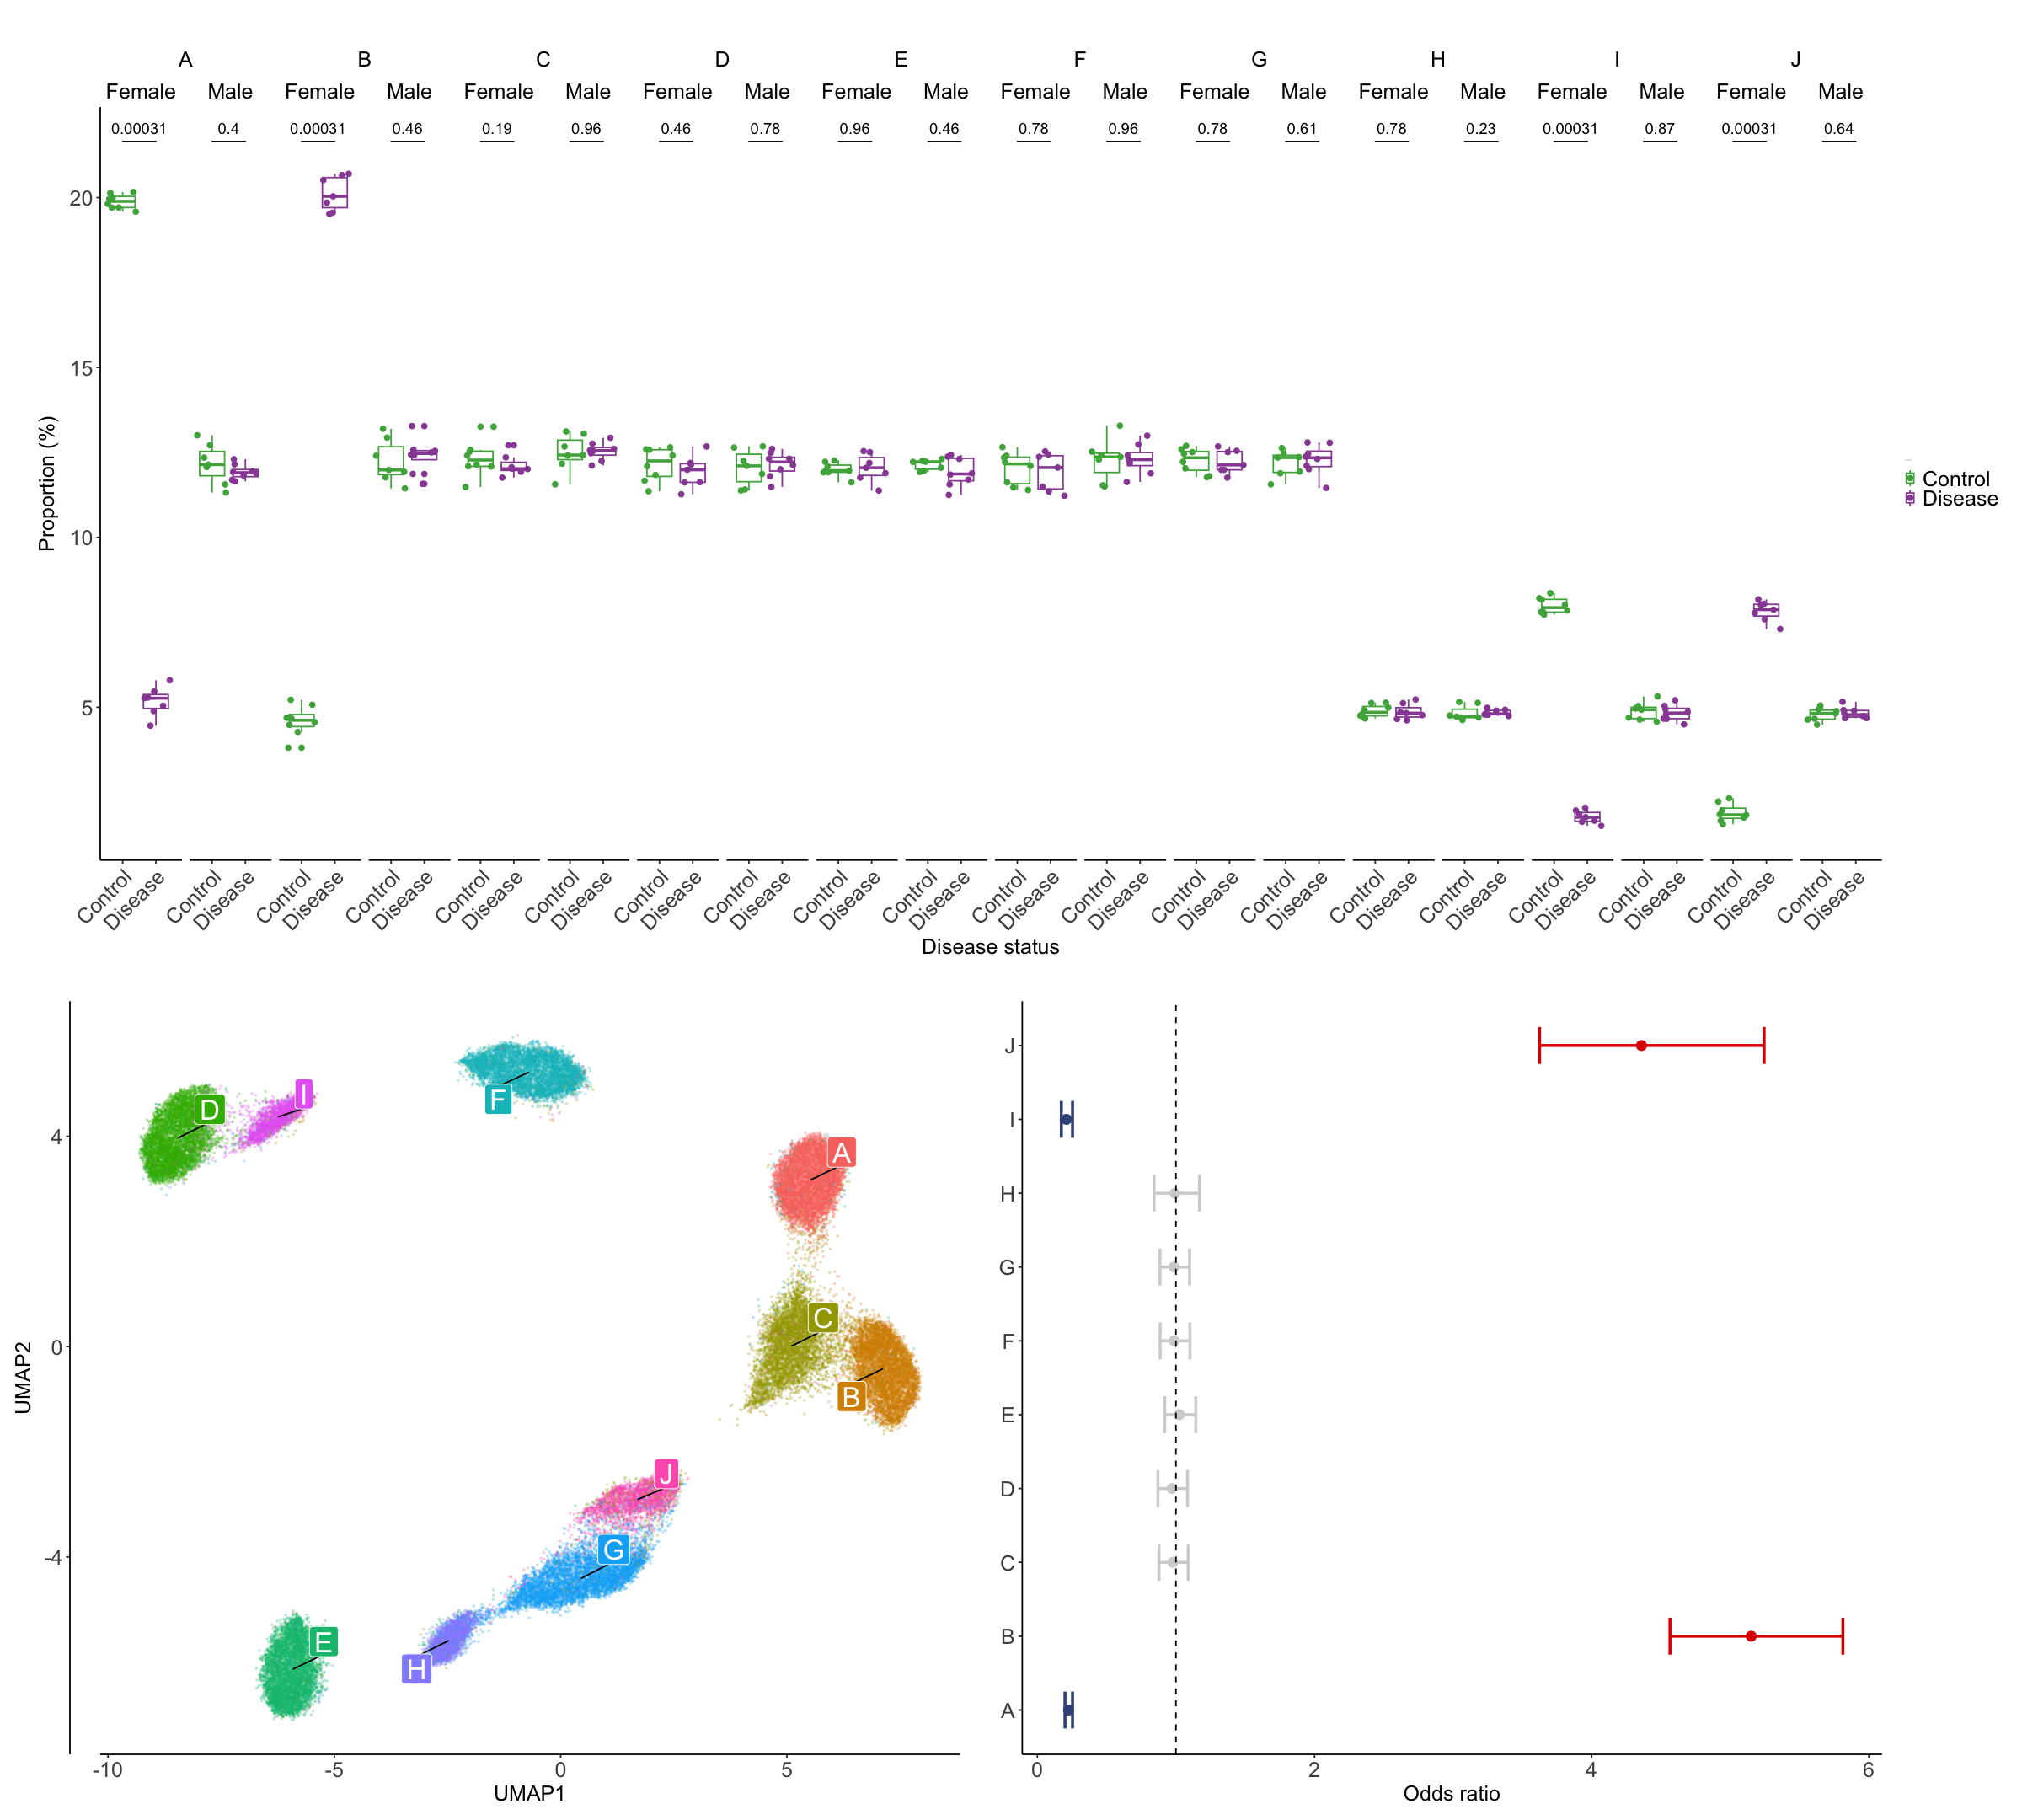

In [142]:
#ix = "visit"
ix = "sex"
options(repr.plot.height = 18, repr.plot.width = 20)
g1 = dummy_data %>%
  #dplyr::group_by(subject_id,visit,disease,cell_type) %>%
  dplyr::group_by(subject_id,sex,disease,cell_type) %>%
  dplyr::summarise(count = dplyr::n()) %>%
  #dplyr::group_by(subject_id,visit,disease) %>%
  dplyr::group_by(subject_id,sex,disease) %>%
  dplyr::mutate(proportion = 100*count/sum(count),
                #ix_label = ifelse(visit==0,"V0","V1"),
                ix_label = ifelse(sex==0,"Male","Female"),
                #disease_label = ifelse(disease=="0","Non-converter","Converter")) %>%
                disease_label = ifelse(disease=="0","Control","Disease")) %>%
  ggplot(.,aes(x=disease_label,y=proportion,color = disease_label)) +
  geom_boxplot() +
  geom_point(position=position_jitterdodge(0.9)) +
  #ggpubr::stat_compare_means(comparisons = list(c("Non-converter","Converter")),
  ggpubr::stat_compare_means(comparisons = list(c("Control","Disease")), 
                             label = "{p.adj}{p.adj.signif}", method = "wilcox.test", label.y.npc = 0.4, tip.length = 0) +
  # scale_color_manual(values = c(
  #   "Non-converter" = "#4DAF4A",
  #   "Converter" = "#984EA3")) +
  scale_color_manual(values = c(
    "Control" = "#4DAF4A",
    "Disease" = "#984EA3")) +
  ggh4x::facet_nested_wrap(vars(cell_type, ix_label), nrow = 1) +
  theme_classic() +
  theme(strip.text.x=element_text(size=15, color="black"),
        strip.text.y=element_text(size=15, color="black"),
        strip.placement = "outside", 
        strip.background.x=element_rect(color = NA,  fill=NA), 
        strip.background.y=element_rect(color = "black",  fill=NA),
        legend.position = "right",
        plot.title = element_text(size=15),
        axis.title.x = element_text(size=15),
        axis.title.y = element_text(size =15),
        axis.text.y = element_text(size = 15),
        axis.text.x = element_text(size = 15, angle = 45, hjust = 1),
        legend.text =  element_text(size = 15),
        legend.key.size = grid::unit(0.5, "lines"),
        legend.title = element_text(size = 0.8, hjust = 0)) +
  labs(
    x = "Disease status",
    y = "Proportion (%)",
    title = ""
  )  

cluster_center <- data.frame(dummy_data, umap_res) %>%
  dplyr::group_by(cell_type) %>%
  dplyr::summarise_at(vars(UMAP1, UMAP2), dplyr::funs(median(., na.rm=TRUE)))
cluster_center <- as.data.frame(cluster_center)
g2 = ggplot() +
  geom_point(
    data = data.frame(dummy_data, umap_res),
    mapping = aes_string(x = "UMAP1", y = "UMAP2", color = "cell_type"),
    size = 1, stroke = 0, shape = 16,alpha = 0.3
  ) +
  geom_label_repel(
    data = cluster_center,
    aes(x = UMAP1, y = UMAP2, label = cell_type, fill = cell_type),
    color = "white",segment.color = "black",
    size = 7,
    min.segment.length = 0, seed = 42, box.padding = 0.8,
    max.overlaps = Inf
  ) +
  labs(
    x = "UMAP1",
    y = "UMAP2",
    title = ""
  ) +
  theme_classic() +
  theme(strip.text.x=element_text(size=15, color="black"),
        strip.text.y=element_text(size=15, color="black"),
        strip.placement = "outside", 
        strip.background.x=element_rect(color = NA,  fill=NA), 
        strip.background.y=element_rect(color = "black",  fill=NA),
        legend.position = "none",
        plot.title = element_text(size=15),
        axis.title.x = element_text(size=15),
        axis.title.y = element_text(size =15),
        axis.text.y = element_text(size = 15),
        axis.text.x = element_text(size = 15),
        legend.text =  element_text(size = 10),
        legend.key.size = grid::unit(0.5, "lines"),
        legend.title = element_text(size = 10, hjust = 0))


g3 = masc %>%
  magrittr::set_colnames(c("cluster","size","model.pvalue","OR","CIlower","CIupper")) %>%
  dplyr::mutate(col = dplyr::case_when(
    CIupper < 1 ~ '#3C5488FF',
    CIlower > 1 ~ '#DC0000FF',
    TRUE ~ "lightgray"),
    CIupper = ifelse(CIupper>30 & model.pvalue>0.05, 1, CIupper),
    CIlower = ifelse(CIlower<0.01 & model.pvalue>0.05, 1, CIlower),
    OR = ifelse(CIupper==1|CIlower==1,1,OR)) %>%
  dplyr::mutate(cluster = gsub("cluster","",cluster)) %>%
  ggplot(., aes(y=cluster, x=OR, colour=col)) + 
  geom_point(position=position_dodge(width=0.3), size=3) +
  geom_errorbarh(aes(xmin=CIlower, xmax=CIupper), position = position_dodge(0.3), height=0.5, linewidth = 1) +
  scale_color_manual(values = c('#3C5488FF' = '#3C5488FF', '#DC0000FF' = '#DC0000FF', "lightgray" = "lightgray")) + 
  geom_vline(xintercept=1, linetype='dashed', color='black') +
  theme_classic() +
  theme(strip.text.x=element_text(size=15, color="black", face="bold"),
        strip.text.y=element_text(size=15, color="black", face="bold"),
        legend.position = "none",
        plot.title = element_text(size=15),
        axis.title.x = element_text(size=15),
        axis.title.y = element_text(size =15),
        axis.text.y = element_text(size =15),
        axis.text.x = element_text(size = 15),
        legend.text =  element_text(size = 15),
        legend.key.size = grid::unit(0.5, "lines"),
        legend.title = element_text(size = 0.8, hjust = 0)) +
  labs(title = "",
       y = "",
       x = "Odds ratio")
(g1) / 
  (g2 + g3)

In [143]:
dim(pcs_matrix)

[1] 49098    20

In [144]:
head(dummy_data)

,sample_id,subject_id,visit,sex,disease,age,batch,bmi,interaction,interact_term,cell_type
,<chr>,<chr>,<int>,<int>,<fct>,<int>,<fct>,<int>,<chr>,<int>,<chr>
2214,SUB_11_V0,SUB_11,0,0,1,31,3,16,sex:disease,0,J
39595,SUB_4_V0,SUB_4,0,1,1,18,4,27,sex:disease,2,I
20642,SUB_21_V1,SUB_21,1,1,1,37,1,28,sex:disease,2,B
22196,SUB_22_V1,SUB_22,1,0,1,22,2,35,sex:disease,0,C
33120,SUB_29_V0,SUB_29,0,0,0,46,1,22,sex:disease,0,E
2288,SUB_11_V0,SUB_11,0,0,1,31,3,16,sex:disease,0,A


### 1.4 Run CNA - generate NAM

In [145]:
dummy_data$condition_val = as.numeric(dummy_data[,disease_col])

nam_res = association_nam(seurat_object=NULL,
                          metadata=dummy_data,
                          pcs=pcs_matrix,
                          test_var=test_var,
                          samplem_key = samplem_key,
                          graph_use = graph_use,
                          batches = batches,
                          covs = c(age_col,sex_col),
                          nsteps = nsteps,
                          verbose=verbose,
                          assay=assay,
                          key=key,
                          maxnsteps=maxnsteps,
                          max_frac_pcs=max_frac_pcs, # added option to pass number of PCs, for potential speedups
                          ks=ks,
                          Nnull=Nnull,
                          force_permute_all=force_permute_all,
                          local_test=local_test,
                          seed=seed,
                          return_nam=return_nam
)

Warning message:
"Data is of class dgTMatrix. Coercing to dgCMatrix."
Computing nearest neighbor graph

Computing SNN

stopping after 4 steps

filtering based on batches kurtosis

throwing out neighborhoods with batch kurtosis >= 6

Residualize NAM

Decompose NAM

Warning message in association_nam(seurat_object = NULL, metadata = dummy_data, :
"global association p-value attained minimal possible value. Consider increasing Nnull"
computing neighborhood-level FDRs

Warning message:
"No assay specified, setting assay as RNA by default."


In [146]:
NAMPC_embeddings <- nam_res@reductions$cna@misc$NAM_embeddings
head(NAMPC_embeddings)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
1,0.006455392,0.0009918361,0.0010436005,0.0017165708,-0.001288937,-0.0020482907,0.0011860690,0.008243615,0.0048386917,-0.0024977832
2,-0.003196114,-0.0049342200,0.0031481602,0.0067418783,0.005995535,0.0003271587,-0.0000149974,-0.009948869,0.0001941945,0.0052569662
3,0.007892959,-0.0002329281,-0.0011581048,-0.0027100583,0.001673902,-0.0006823681,0.0011545163,-0.003904277,0.0016194419,-0.0006002003
4,-0.001380627,0.0021368692,0.0005790189,-0.0009061861,-0.003199007,-0.0079263457,0.0039171507,0.006759615,0.0048251689,0.0086713797
5,0.003524153,-0.0057225547,-0.0032403684,-0.0061821869,0.009692918,-0.0021287607,-0.0004835988,-0.007488351,-0.0003948273,-0.0038400240
6,-0.007288764,0.0001517456,-0.0012772544,0.0016197851,-0.003875898,0.0030959469,0.0014090821,0.001956486,-0.0012013757,0.0018455409


Warning message:
"did not converge in 25 iterations"
Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 2454900)"


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
1,0.0063262499,0.0017874221,0.0017984342,0.0015203214,-0.0003857927,-0.0017322614,-0.0002960967,0.007446915,0.0048275925,-0.0016500146
2,-0.0024392144,-0.0046264723,0.0022991728,0.0080511432,0.0037698645,-0.0012889581,-0.0004860834,-0.007893862,0.0028036263,0.0044741641
3,0.0076696168,-0.0005519391,-0.0014002881,-0.0031118511,0.0015244727,0.0002456263,0.0003810978,-0.004181037,0.0008345889,-0.0004896569
4,-0.0003677877,0.0003286769,0.0012436349,-0.0002194609,-0.0039459725,-0.0070678937,0.0036151121,0.006228060,0.0026750213,0.0060963456
5,0.0033030073,-0.0054728442,-0.0030113540,-0.0045923680,0.0101919012,-0.0010018705,-0.0007270346,-0.007192725,-0.0005574424,-0.0032727066
6,-0.0072456334,0.0007631644,-0.0008356557,0.0016681083,-0.0029564526,0.0033815393,0.0007105087,0.001492755,-0.0008946720,0.0021363052


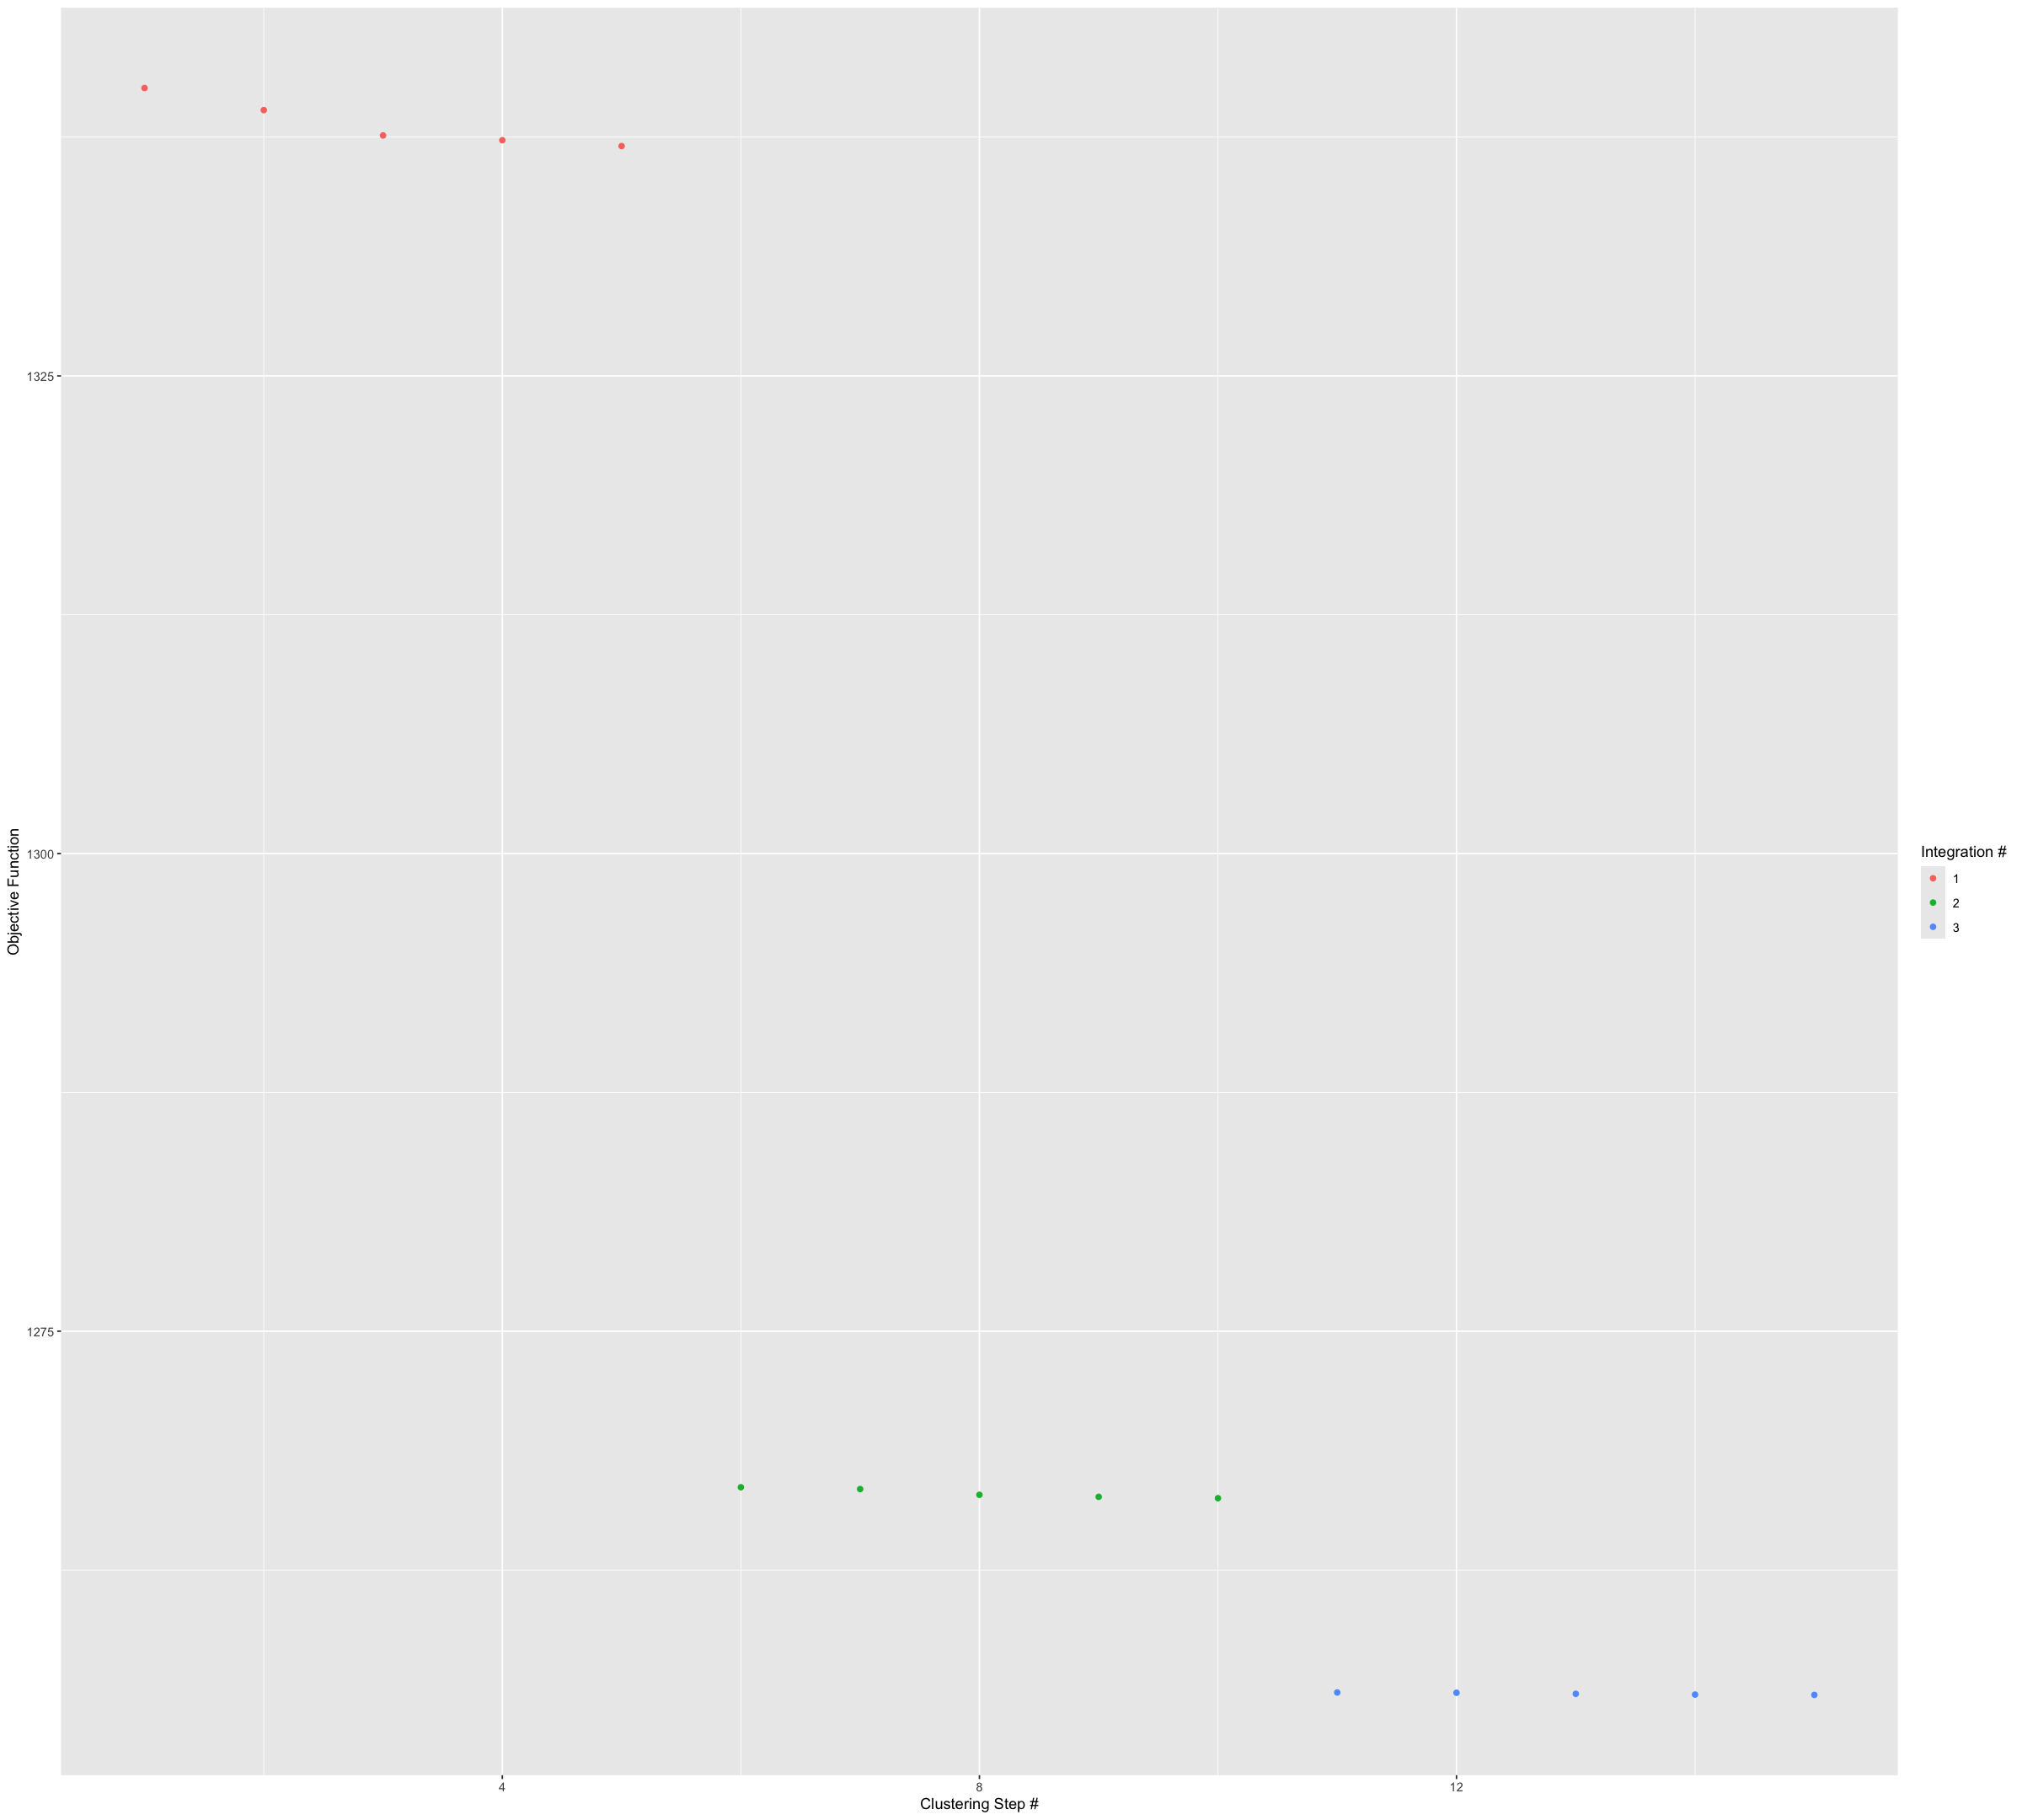

In [147]:
# harmonize NAM PC embeddings
library(harmony)
# used the "sample_id" column since this includes the visit as well, e.g., SUB_8_V1
# (subject id does not include visit information (SUB_8))
harmonized_NAMPC_embeddings <- RunHarmony(NAMPC_embeddings, dummy_data, 'sample_id', verbose=FALSE, theta = 4,
  max_iter = 10, plot_convergence = TRUE)
#colnames(harmonized_NAMPC_embeddings) <- paste0("PC", 1:ncol(pcs_matrix))
colnames(harmonized_NAMPC_embeddings) <- colnames(NAMPC_embeddings)
head(harmonized_NAMPC_embeddings)

In [148]:
file_name = paste0("/Users/zhanglab_mac2/Documents/GitHub/CellPhenoX-Analyses/src/interaction_analyses/simulated_data/simulated_inter_PCs",
                    "_sd", sd_celltypes,
                    "_fci", fc_interact,
                    "_TYPE", interaction_type,
                    "_clusterRatio", cluster_ratio,
                    "_diseaseRatio", disease_ratio,
                    "_interFeature", interaction_feature,
                    ".csv")
write.csv(harmonized_NAMPC_embeddings, file=file_name, row.names=FALSE, col.names=TRUE)

Warning message in write.csv(harmonized_NAMPC_embeddings, file = file_name, row.names = FALSE, :
"attempt to set 'col.names' ignored"


In [149]:
dummy_data_with_umap <- cbind(dummy_data, umap_res)
file_name = paste0("/Users/zhanglab_mac2/Documents/GitHub/CellPhenoX-Analyses/src/interaction_analyses/simulated_data/simulated_inter_meta",
                    "_sd", sd_celltypes,
                    "_fci", fc_interact,
                    "_TYPE", interaction_type,
                    "_clusterRatio", cluster_ratio,
                    "_diseaseRatio", disease_ratio,
                    "_interFeature", interaction_feature,
                    ".csv")
write.csv(dummy_data_with_umap, file=file_name, row.names=TRUE, col.names=TRUE)

Warning message in write.csv(dummy_data_with_umap, file = file_name, row.names = TRUE, :
"attempt to set 'col.names' ignored"


## 2. Second Situation

In [168]:
source("./functions_sim.R")

In [154]:
n_cells=100 # cells per individual
sd_celltypes=0.1  # standard deviation of number of cells 
n_major_cell_types=7
n_minor_cell_types=3
relative_abundance=0.4 # ratio between major and rare
n_major_interact_celltypes=2
n_minor_interact_celltypes=2
n_individuals=30 # total individuals
n_batchs=4
prop_sex=0.5 # proportion of feature 1 if feature 1 is categorical variable
prop_disease=0.5  # proportion of feature 2 if feature 2 is categorical variable
interaction_feature="sex" #"visit"
test_var="condition_val"
time_points = 2

# difference in proportion of cells 
# proportion of interacted cells which are from people with interacted group
fc_interact=0.6 #0.3 
# specific, hardest scenario, significant difference in cell proportions for just one time point (V1)
# differential, scenario, significant difference in cell proportions for both time points
# opposite, simplest scenario, difference in cell proportions is low in one time point and high in the other
interaction_type="specific" # c("specific","differential","opposite")
seed=1234

n_pcs = 20
cluster_pcs = 1:20
disease_pcs = 0
sex_pcs = 0 # seq(2, 20, by = 2)
age_pcs = 0 # seq(2, 10, by = 2)
bmi_pcs = 0 # seq(11, 20, by = 2)
batch_pcs = 0 # seq(1, 20,by = 2)
interaction_pcs = 0
visit_pcs = 0
subject_pcs = 0
# Define the maximum variance of each attribute
cluster_ratio = 0.8
disease_ratio = 0
sex_ratio = 0 # 0.05
age_ratio = 0 # 0.05
bmi_ratio = 0 # 0.05
batch_ratio = 0 # 0.1
visit_ratio = 0
interaction_ratio = 0
subject_ratio = 0

scale_factor = 5

cluster_col = "cell_type"
sex_col = "sex"
age_col = "age"
bmi_col = "bmi"
batch_col = "batch"
disease_col = "disease"
visit_col = "visit"
samplem_key = 'sample_id'

# parameters for UMAP
n_neighbors = 30
metric = "cosine"
min_dist = 0.01

# parameters for CNA
test_var="condition_val"
samplem_key = 'subject_id'
graph_use = 'RNA_nn'
batches = "batch"

nsteps = NULL
verbose=TRUE
assay=NULL
key='NAMPC_'
maxnsteps=15L
max_frac_pcs=0.15
ks=NULL
Nnull=1000
force_permute_all=FALSE
local_test=TRUE
return_nam=TRUE

### 2.1 Generating Dummy Data

In [169]:
dummy_data = generate_dummy_data_time(n_cells = n_cells, # cells of major cell types per individual
                                      sd_celltypes = sd_celltypes,  # standard deviation of number of cells 
                                      n_major_cell_types = n_major_cell_types,
                                      n_minor_cell_types = n_minor_cell_types,
                                      relative_abundance = relative_abundance, # ratio between major and rare
                                      n_major_interact_celltypes = n_major_interact_celltypes,
                                      n_minor_interact_celltypes = n_minor_interact_celltypes,
                                      
                                      n_individuals = n_individuals, # total individuals
                                      n_batchs = n_batchs,
                                      
                                      interaction_feature = interaction_feature,
                                      time_points = time_points,
                                      
                                      test_var = disease_col,
                                      prop_disease = prop_disease,  
                                      
                                      fc_interact = fc_interact, # additional proportion of interacted cells which are from people with interacted group compared to non-interacted cell types
                                      interaction_type = interaction_type,
                                      seed = seed)
interact_cell_types = dummy_data[[2]]
dummy_data = dummy_data[[1]]

interact_cell_types
head(dummy_data)

  subject_id sample_id visit sex disease age batch bmi interaction
1      SUB_1  SUB_1_V0     0   1       1  40     1  17 sex:disease
2      SUB_2  SUB_2_V0     0   1       1  58     2  23 sex:disease
3      SUB_3  SUB_3_V0     0   0       1  59     3  27 sex:disease
4      SUB_4  SUB_4_V0     0   0       1  50     4  26 sex:disease
5      SUB_5  SUB_5_V0     0   0       0  60     1  30 sex:disease
6      SUB_6  SUB_6_V0     0   0       0  40     2  25 sex:disease
  subject_id sample_id visit sex disease age batch bmi interaction
1      SUB_1  SUB_1_V0     0   1       1  40     1  17 sex:disease
2      SUB_2  SUB_2_V0     0   1       1  58     2  23 sex:disease
3      SUB_3  SUB_3_V0     0   0       1  59     3  27 sex:disease
4      SUB_4  SUB_4_V0     0   0       1  50     4  26 sex:disease
5      SUB_5  SUB_5_V0     0   0       0  60     1  30 sex:disease
6      SUB_6  SUB_6_V0     0   0       0  40     2  25 sex:disease
  interact_term
1             2
2             2
3             

[1] "A" "B" "I" "J"

,sample_id,subject_id,visit,sex,disease,age,batch,bmi,interaction,interact_term,cell_type
,<chr>,<chr>,<int>,<int>,<fct>,<int>,<fct>,<int>,<chr>,<int>,<chr>
40156,SUB_30_V1,SUB_30,1,1,1,53,2,21,sex:disease,2,D
8471,SUB_14_V1,SUB_14,1,1,1,52,2,17,sex:disease,2,A
26539,SUB_24_V0,SUB_24,0,1,0,32,4,34,sex:disease,1,E
33187,SUB_27_V1,SUB_27,1,1,1,44,3,29,sex:disease,2,C
29354,SUB_25_V1,SUB_25,1,1,1,57,1,15,sex:disease,2,B
18925,SUB_1_V1,SUB_1,1,1,1,40,1,17,sex:disease,2,B


In [170]:
pcs_matrix = generate_pseudo_pcs_time(dummy_data, 
                                             n_pcs = n_pcs, 
                                             cluster_pcs = cluster_pcs,
                                             disease_pcs = disease_pcs,
                                             sex_pcs = sex_pcs, 
                                             age_pcs = age_pcs,
                                             bmi_pcs = bmi_pcs,
                                             batch_pcs = batch_pcs,
                                             interaction_pcs = interaction_pcs,
                                             visit_pcs = visit_pcs,
                                             subject_pcs = subject_pcs,
                                             
                                             # 各属性の割合の最大値を定義
                                             cluster_ratio = cluster_ratio,
                                             disease_ratio = disease_ratio,
                                             sex_ratio = sex_ratio,
                                             age_ratio = age_ratio,
                                             bmi_ratio = bmi_ratio,
                                             batch_ratio = batch_ratio,
                                             interaction_ratio = interaction_ratio,
                                             visit_ratio = visit_ratio,
                                             subject_ratio = subject_ratio,
                                             
                                             scale_factor = scale_factor,
                                             
                                             cluster_col = cluster_col,
                                             sex_col = sex_col,
                                             age_col = age_col,
                                             bmi_col = bmi_col,
                                             batch_col = batch_col,
                                             disease_col = disease_col,
                                             visit_col = visit_col,
                                             seed = seed
                                             # interact_term_col = "interact_term"
)
colnames(pcs_matrix) <- paste0("PC", 1:ncol(pcs_matrix))

umap_res <- uwot::umap(pcs_matrix, 
                       n_neighbors = n_neighbors, 
                       metric = "cosine", 
                       min_dist = min_dist)
umap_res = umap_res %>% 
  magrittr::set_colnames(c("UMAP1","UMAP2")) %>%
  as.data.frame()

In [171]:
head(pcs_matrix)

PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0.27334973,0.62481415,0.09919354,-0.3947941,0.06480405,0.135441332,0.004784323,-0.03154840,-0.2062273,0.23097298,0.1038459,-0.085729572,-0.13306786,-0.04999156,-0.12013758,-0.014166187,0.13879361,0.03095680,0.05360243,-0.17508821
-1.10091732,0.01715046,0.38016742,-0.4260808,-0.24283203,-0.037171701,0.127785107,-0.13021608,-0.1618861,0.23682416,-0.1253883,0.108742575,-0.04015276,0.10609579,-0.10951693,0.092872988,0.12395714,0.06451633,0.10975169,0.04804557
-1.67050606,0.40039486,-0.31730726,0.2139084,0.12254052,-0.046238000,-0.068731433,-0.34737901,0.1364915,-0.02533810,0.1288539,-0.129545744,-0.10666510,-0.21677173,0.30172227,-0.088881348,0.02390061,0.07399797,-0.01102215,0.10031096
0.86172575,0.28152020,-0.34066264,-0.2752679,0.22716616,0.257898440,-0.134037515,0.06565717,-0.2536412,-0.07834479,-0.1953854,-0.108540068,-0.17726234,-0.19060558,-0.01747015,0.056235897,0.31384514,0.03606408,-0.02941139,0.01122321
0.05977594,-0.14887483,-0.18006675,0.1474018,0.14553176,-0.001589667,0.125746614,0.05023227,-0.1329368,0.05607136,-0.1351531,0.127951927,0.17177643,0.21806371,0.12744129,-0.005300865,-0.02398308,0.14291431,-0.02428785,0.17677508
0.47416756,0.21108010,-0.04381267,0.4495508,0.20199709,-0.220481336,0.367971275,-0.09065409,0.1209177,-0.17299510,-0.1036684,-0.004087424,0.15380474,-0.02591716,-0.02707195,0.041671002,-0.14727543,0.02737436,0.10858917,0.10062059


### 2.2 Mixed Effect Model

In [172]:
masc_df = dummy_data
masc_df$subject_id = factor(masc_df$subject_id)
masc_df$sample_id = factor(masc_df$sample_id)

masc = GLM_interact(dataset = masc_df,
                    cluster = masc_df$cell_type,
                    contrast1 = interaction_feature,
                    contrast2 = disease_col,
                    random_effects = samplem_key,
                    fixed_effects = NULL,
                    verbose = TRUE, save_models = FALSE)
masc

Using null model: cluster ~ (1|subject_id) + sex + disease

Using full model: cluster ~ (1|subject_id) + sex + disease + sex:disease

Creating logistic mixed models for clusterA

boundary (singular) fit: see help('isSingular')

Creating logistic mixed models for clusterB

boundary (singular) fit: see help('isSingular')

Creating logistic mixed models for clusterC

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

Creating logistic mixed models for clusterD

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

Creating logistic mixed models for clusterE

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

Creating logistic mixed models for clusterF

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

Creating logistic mixed models for clusterG

boundary (singular) fit: see help('isSingular')

boundary (si

,cluster,size,model.pvalue,sex:disease1.OR,sex:disease1.OR.95pct.ci.lower,sex:disease1.OR.95pct.ci.upper
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
clusterA,clusterA,7155,3.452001e-21,0.4085166,0.3679464,0.4535602
clusterB,clusterB,7133,5.858421e-18,1.9868938,1.7777086,2.2206941
clusterC,clusterC,5984,1.647222e-02,1.1500861,1.0257580,1.2894835
clusterD,clusterD,5970,1.114129e-01,1.0971513,0.9788391,1.2297640
clusterE,clusterE,5944,1.222049e-02,1.1578437,1.0321658,1.2988242
clusterF,clusterF,6021,3.703988e-02,1.1288065,1.0069271,1.2654383
clusterG,clusterG,5995,1.363966e-01,1.0904355,0.9730203,1.2220192
clusterH,clusterH,2400,6.799961e-01,1.0370958,0.8722228,1.2331343
clusterI,clusterI,2885,5.395089e-16,0.4331284,0.3700620,0.5069425


### 2.3 Visualization

`summarise()` has grouped output by 'subject_id', 'sex', 'disease'. You can
override using the `.groups` argument.
Warning message:
"`funs()` was deprecated in dplyr 0.8.0.
i Please use a list of either functions or lambdas:

# Simple named list: list(mean = mean, median = median)

# Auto named with `tibble::lst()`: tibble::lst(mean, median)

# Using lambdas list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))"
Warning message in wilcox.test.default(c(12.0793269230769, 11.4963503649635, 12.6716604244694, :
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(c(12.4399038461538, 11.9829683698297, 12.2971285892634, :
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(c(4.74759615384615, 5.17031630170316, 4.99375780274657, :
"cannot compute exact p-value with ties"


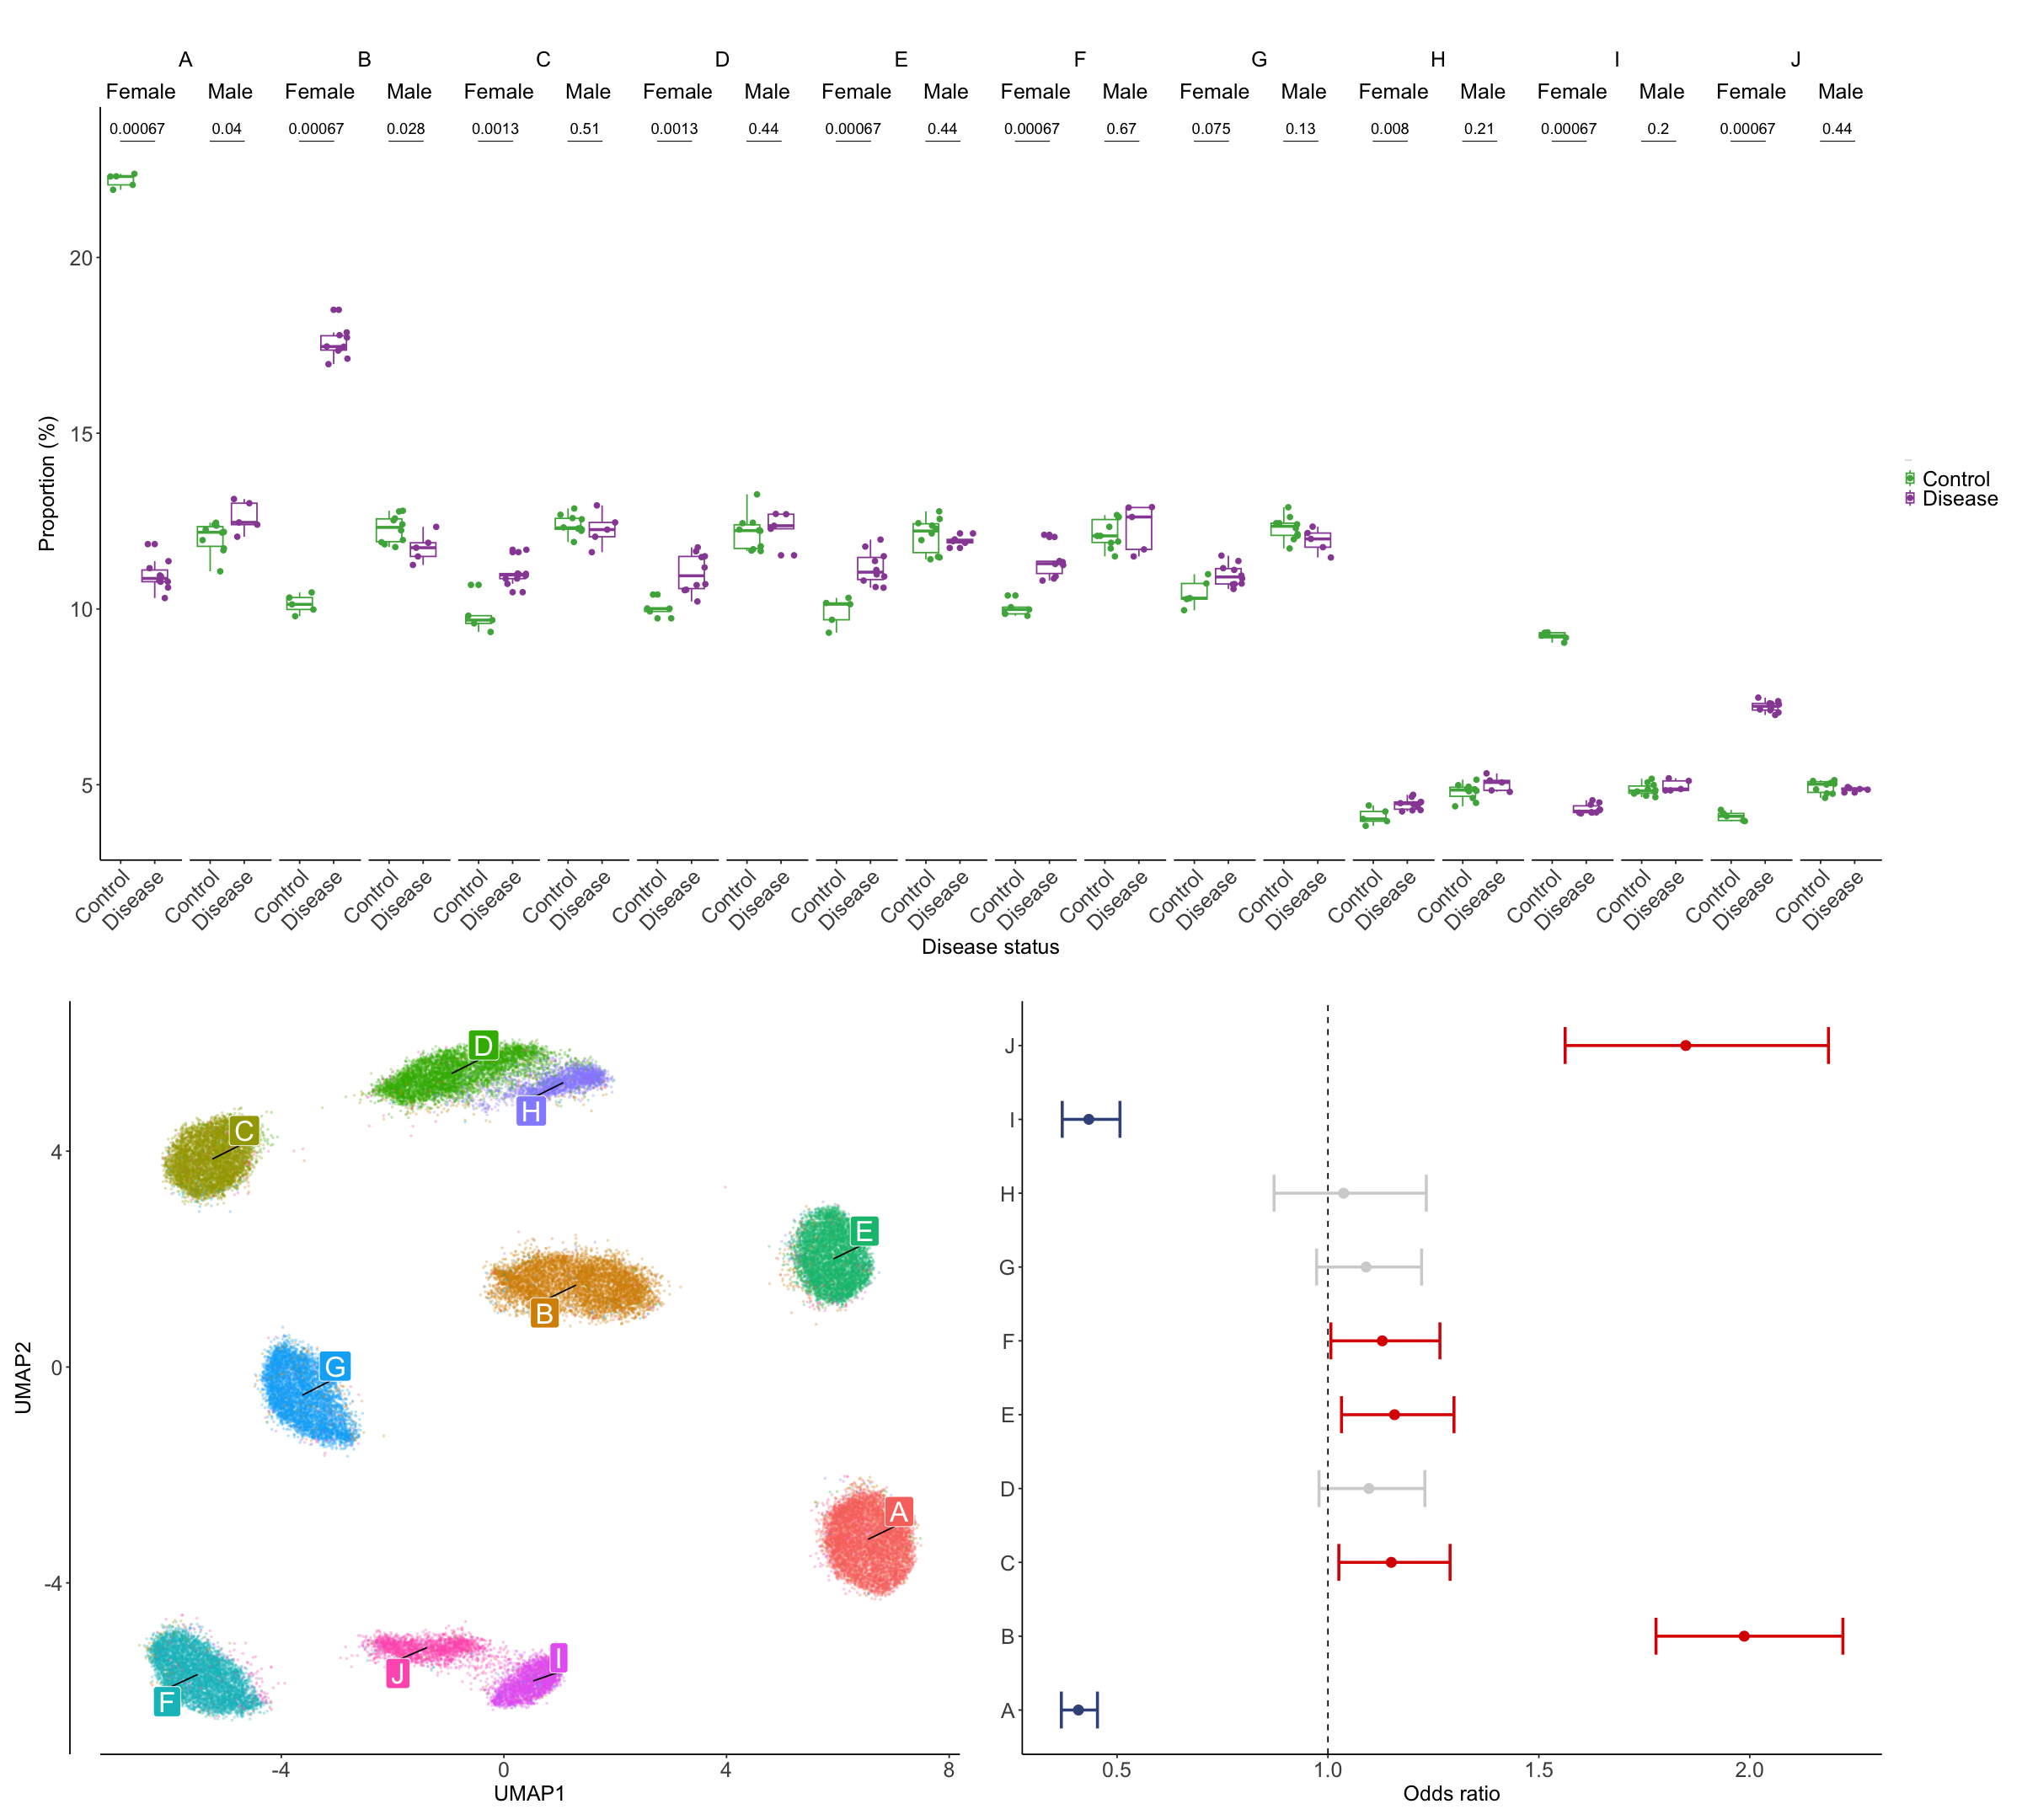

In [173]:
#ix = "visit"
ix = "sex"
options(repr.plot.height = 18, repr.plot.width = 20)
g1 = dummy_data %>%
  #dplyr::group_by(subject_id,visit,disease,cell_type) %>%
  dplyr::group_by(subject_id,sex,disease,cell_type) %>%
  dplyr::summarise(count = dplyr::n()) %>%
  #dplyr::group_by(subject_id,visit,disease) %>%
  dplyr::group_by(subject_id,sex,disease) %>%
  dplyr::mutate(proportion = 100*count/sum(count),
                #ix_label = ifelse(visit==0,"V0","V1"),
                ix_label = ifelse(sex==0,"Male","Female"),
                #disease_label = ifelse(disease=="0","Non-converter","Converter")) %>%
                disease_label = ifelse(disease=="0","Control","Disease")) %>%
  ggplot(.,aes(x=disease_label,y=proportion,color = disease_label)) +
  geom_boxplot() +
  geom_point(position=position_jitterdodge(0.9)) +
  #ggpubr::stat_compare_means(comparisons = list(c("Non-converter","Converter")),
  ggpubr::stat_compare_means(comparisons = list(c("Control","Disease")), 
                             label = "{p.adj}{p.adj.signif}", method = "wilcox.test", label.y.npc = 0.4, tip.length = 0) +
  # scale_color_manual(values = c(
  #   "Non-converter" = "#4DAF4A",
  #   "Converter" = "#984EA3")) +
  scale_color_manual(values = c(
    "Control" = "#4DAF4A",
    "Disease" = "#984EA3")) +
  ggh4x::facet_nested_wrap(vars(cell_type, ix_label), nrow = 1) +
  theme_classic() +
  theme(strip.text.x=element_text(size=15, color="black"),
        strip.text.y=element_text(size=15, color="black"),
        strip.placement = "outside", 
        strip.background.x=element_rect(color = NA,  fill=NA), 
        strip.background.y=element_rect(color = "black",  fill=NA),
        legend.position = "right",
        plot.title = element_text(size=15),
        axis.title.x = element_text(size=15),
        axis.title.y = element_text(size =15),
        axis.text.y = element_text(size = 15),
        axis.text.x = element_text(size = 15, angle = 45, hjust = 1),
        legend.text =  element_text(size = 15),
        legend.key.size = grid::unit(0.5, "lines"),
        legend.title = element_text(size = 0.8, hjust = 0)) +
  labs(
    x = "Disease status",
    y = "Proportion (%)",
    title = ""
  )  

cluster_center <- data.frame(dummy_data, umap_res) %>%
  dplyr::group_by(cell_type) %>%
  dplyr::summarise_at(vars(UMAP1, UMAP2), dplyr::funs(median(., na.rm=TRUE)))
cluster_center <- as.data.frame(cluster_center)
g2 = ggplot() +
  geom_point(
    data = data.frame(dummy_data, umap_res),
    mapping = aes_string(x = "UMAP1", y = "UMAP2", color = "cell_type"),
    size = 1, stroke = 0, shape = 16,alpha = 0.3
  ) +
  geom_label_repel(
    data = cluster_center,
    aes(x = UMAP1, y = UMAP2, label = cell_type, fill = cell_type),
    color = "white",segment.color = "black",
    size = 7,
    min.segment.length = 0, seed = 42, box.padding = 0.8,
    max.overlaps = Inf
  ) +
  labs(
    x = "UMAP1",
    y = "UMAP2",
    title = ""
  ) +
  theme_classic() +
  theme(strip.text.x=element_text(size=15, color="black"),
        strip.text.y=element_text(size=15, color="black"),
        strip.placement = "outside", 
        strip.background.x=element_rect(color = NA,  fill=NA), 
        strip.background.y=element_rect(color = "black",  fill=NA),
        legend.position = "none",
        plot.title = element_text(size=15),
        axis.title.x = element_text(size=15),
        axis.title.y = element_text(size =15),
        axis.text.y = element_text(size = 15),
        axis.text.x = element_text(size = 15),
        legend.text =  element_text(size = 10),
        legend.key.size = grid::unit(0.5, "lines"),
        legend.title = element_text(size = 10, hjust = 0))


g3 = masc %>%
  magrittr::set_colnames(c("cluster","size","model.pvalue","OR","CIlower","CIupper")) %>%
  dplyr::mutate(col = dplyr::case_when(
    CIupper < 1 ~ '#3C5488FF',
    CIlower > 1 ~ '#DC0000FF',
    TRUE ~ "lightgray"),
    CIupper = ifelse(CIupper>30 & model.pvalue>0.05, 1, CIupper),
    CIlower = ifelse(CIlower<0.01 & model.pvalue>0.05, 1, CIlower),
    OR = ifelse(CIupper==1|CIlower==1,1,OR)) %>%
  dplyr::mutate(cluster = gsub("cluster","",cluster)) %>%
  ggplot(., aes(y=cluster, x=OR, colour=col)) + 
  geom_point(position=position_dodge(width=0.3), size=3) +
  geom_errorbarh(aes(xmin=CIlower, xmax=CIupper), position = position_dodge(0.3), height=0.5, linewidth = 1) +
  scale_color_manual(values = c('#3C5488FF' = '#3C5488FF', '#DC0000FF' = '#DC0000FF', "lightgray" = "lightgray")) + 
  geom_vline(xintercept=1, linetype='dashed', color='black') +
  theme_classic() +
  theme(strip.text.x=element_text(size=15, color="black", face="bold"),
        strip.text.y=element_text(size=15, color="black", face="bold"),
        legend.position = "none",
        plot.title = element_text(size=15),
        axis.title.x = element_text(size=15),
        axis.title.y = element_text(size =15),
        axis.text.y = element_text(size =15),
        axis.text.x = element_text(size = 15),
        legend.text =  element_text(size = 15),
        legend.key.size = grid::unit(0.5, "lines"),
        legend.title = element_text(size = 0.8, hjust = 0)) +
  labs(title = "",
       y = "",
       x = "Odds ratio")
(g1) / 
  (g2 + g3)

### 2.4 Run CNA - generate NAM

In [174]:
dummy_data$condition_val = as.numeric(dummy_data[,disease_col])

nam_res = association_nam(seurat_object=NULL,
                          metadata=dummy_data,
                          pcs=pcs_matrix,
                          test_var=test_var,
                          samplem_key = samplem_key,
                          graph_use = graph_use,
                          batches = batches,
                          covs = c(age_col,sex_col),
                          nsteps = nsteps,
                          verbose=verbose,
                          assay=assay,
                          key=key,
                          maxnsteps=maxnsteps,
                          max_frac_pcs=max_frac_pcs, # added option to pass number of PCs, for potential speedups
                          ks=ks,
                          Nnull=Nnull,
                          force_permute_all=force_permute_all,
                          local_test=local_test,
                          seed=seed,
                          return_nam=return_nam
)

Warning message:
"Data is of class dgTMatrix. Coercing to dgCMatrix."
Computing nearest neighbor graph

Computing SNN

stopping after 4 steps

filtering based on batches kurtosis

throwing out neighborhoods with batch kurtosis >= 6

Residualize NAM

Decompose NAM

Warning message in association_nam(seurat_object = NULL, metadata = dummy_data, :
"data supported use of 5 NAM PCs, which is the maximum considered. Consider allowing more PCs by using the "ks" argument."
Warning message in association_nam(seurat_object = NULL, metadata = dummy_data, :
"global association p-value attained minimal possible value. Consider increasing Nnull"
computing neighborhood-level FDRs

Warning message:
"No assay specified, setting assay as RNA by default."


In [175]:
NAMPC_embeddings <- nam_res@reductions$cna@misc$NAM_embeddings
head(NAMPC_embeddings)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
1,0.003045316,5.441372e-04,-0.0023527158,-0.007734612,-9.829343e-04,0.0001077325,-0.001852038,-2.434296e-04,0.001175671,-0.007703466
2,-0.008387430,-1.471835e-05,-0.0013094842,0.001252164,3.082105e-04,0.0017831962,-0.002932901,5.179426e-05,0.002790862,-0.003746912
3,-0.004659656,-5.250835e-03,-0.0017704558,0.003880430,-2.145639e-05,0.0043369579,-0.004030559,4.427601e-04,0.002129806,0.001452221
4,0.002582866,-3.258751e-03,0.0002416378,0.004134677,2.080464e-03,-0.0093609335,-0.002533232,-2.007654e-03,-0.004934200,0.001239930
5,0.006919706,-4.773879e-03,0.0036125039,-0.005017274,-5.058120e-04,0.0018105337,-0.001504622,-1.452647e-03,0.003676328,-0.002324436
6,0.005973415,5.616914e-03,0.0038540724,-0.003847426,6.636168e-03,-0.0017381028,-0.001888325,3.147254e-03,-0.003867475,0.002584550


Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 2620000)"
Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 2620000)"


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
1,0.002395915,0.0002909476,-4.792598e-03,-0.0072176788,-0.0009131219,0.0007762196,-0.0027351213,-0.0012245707,0.001967916,-8.343566e-03
2,-0.008255107,-0.0007553423,-1.044089e-03,0.0009592664,0.0013462603,0.0016867435,-0.0032846998,0.0002402058,0.003368545,-3.449142e-03
3,-0.004062990,-0.0044232855,-3.008673e-03,0.0038103241,-0.0004651484,0.0051718004,-0.0040398034,-0.0001340109,0.002663340,1.323512e-03
4,0.001754637,-0.0038897481,4.906631e-05,0.0037585959,0.0031036251,-0.0111207279,-0.0015642581,-0.0030427441,-0.004516100,-1.499258e-05
5,0.006484947,-0.0039719386,2.450420e-03,-0.0039679069,0.0012985375,0.0023849840,-0.0016341203,-0.0016816384,0.004107841,-1.775355e-03
6,0.005435941,0.0058789132,5.390763e-03,-0.0047171173,0.0069634132,-0.0018616916,-0.0005807044,0.0040821060,-0.004789626,2.061377e-03


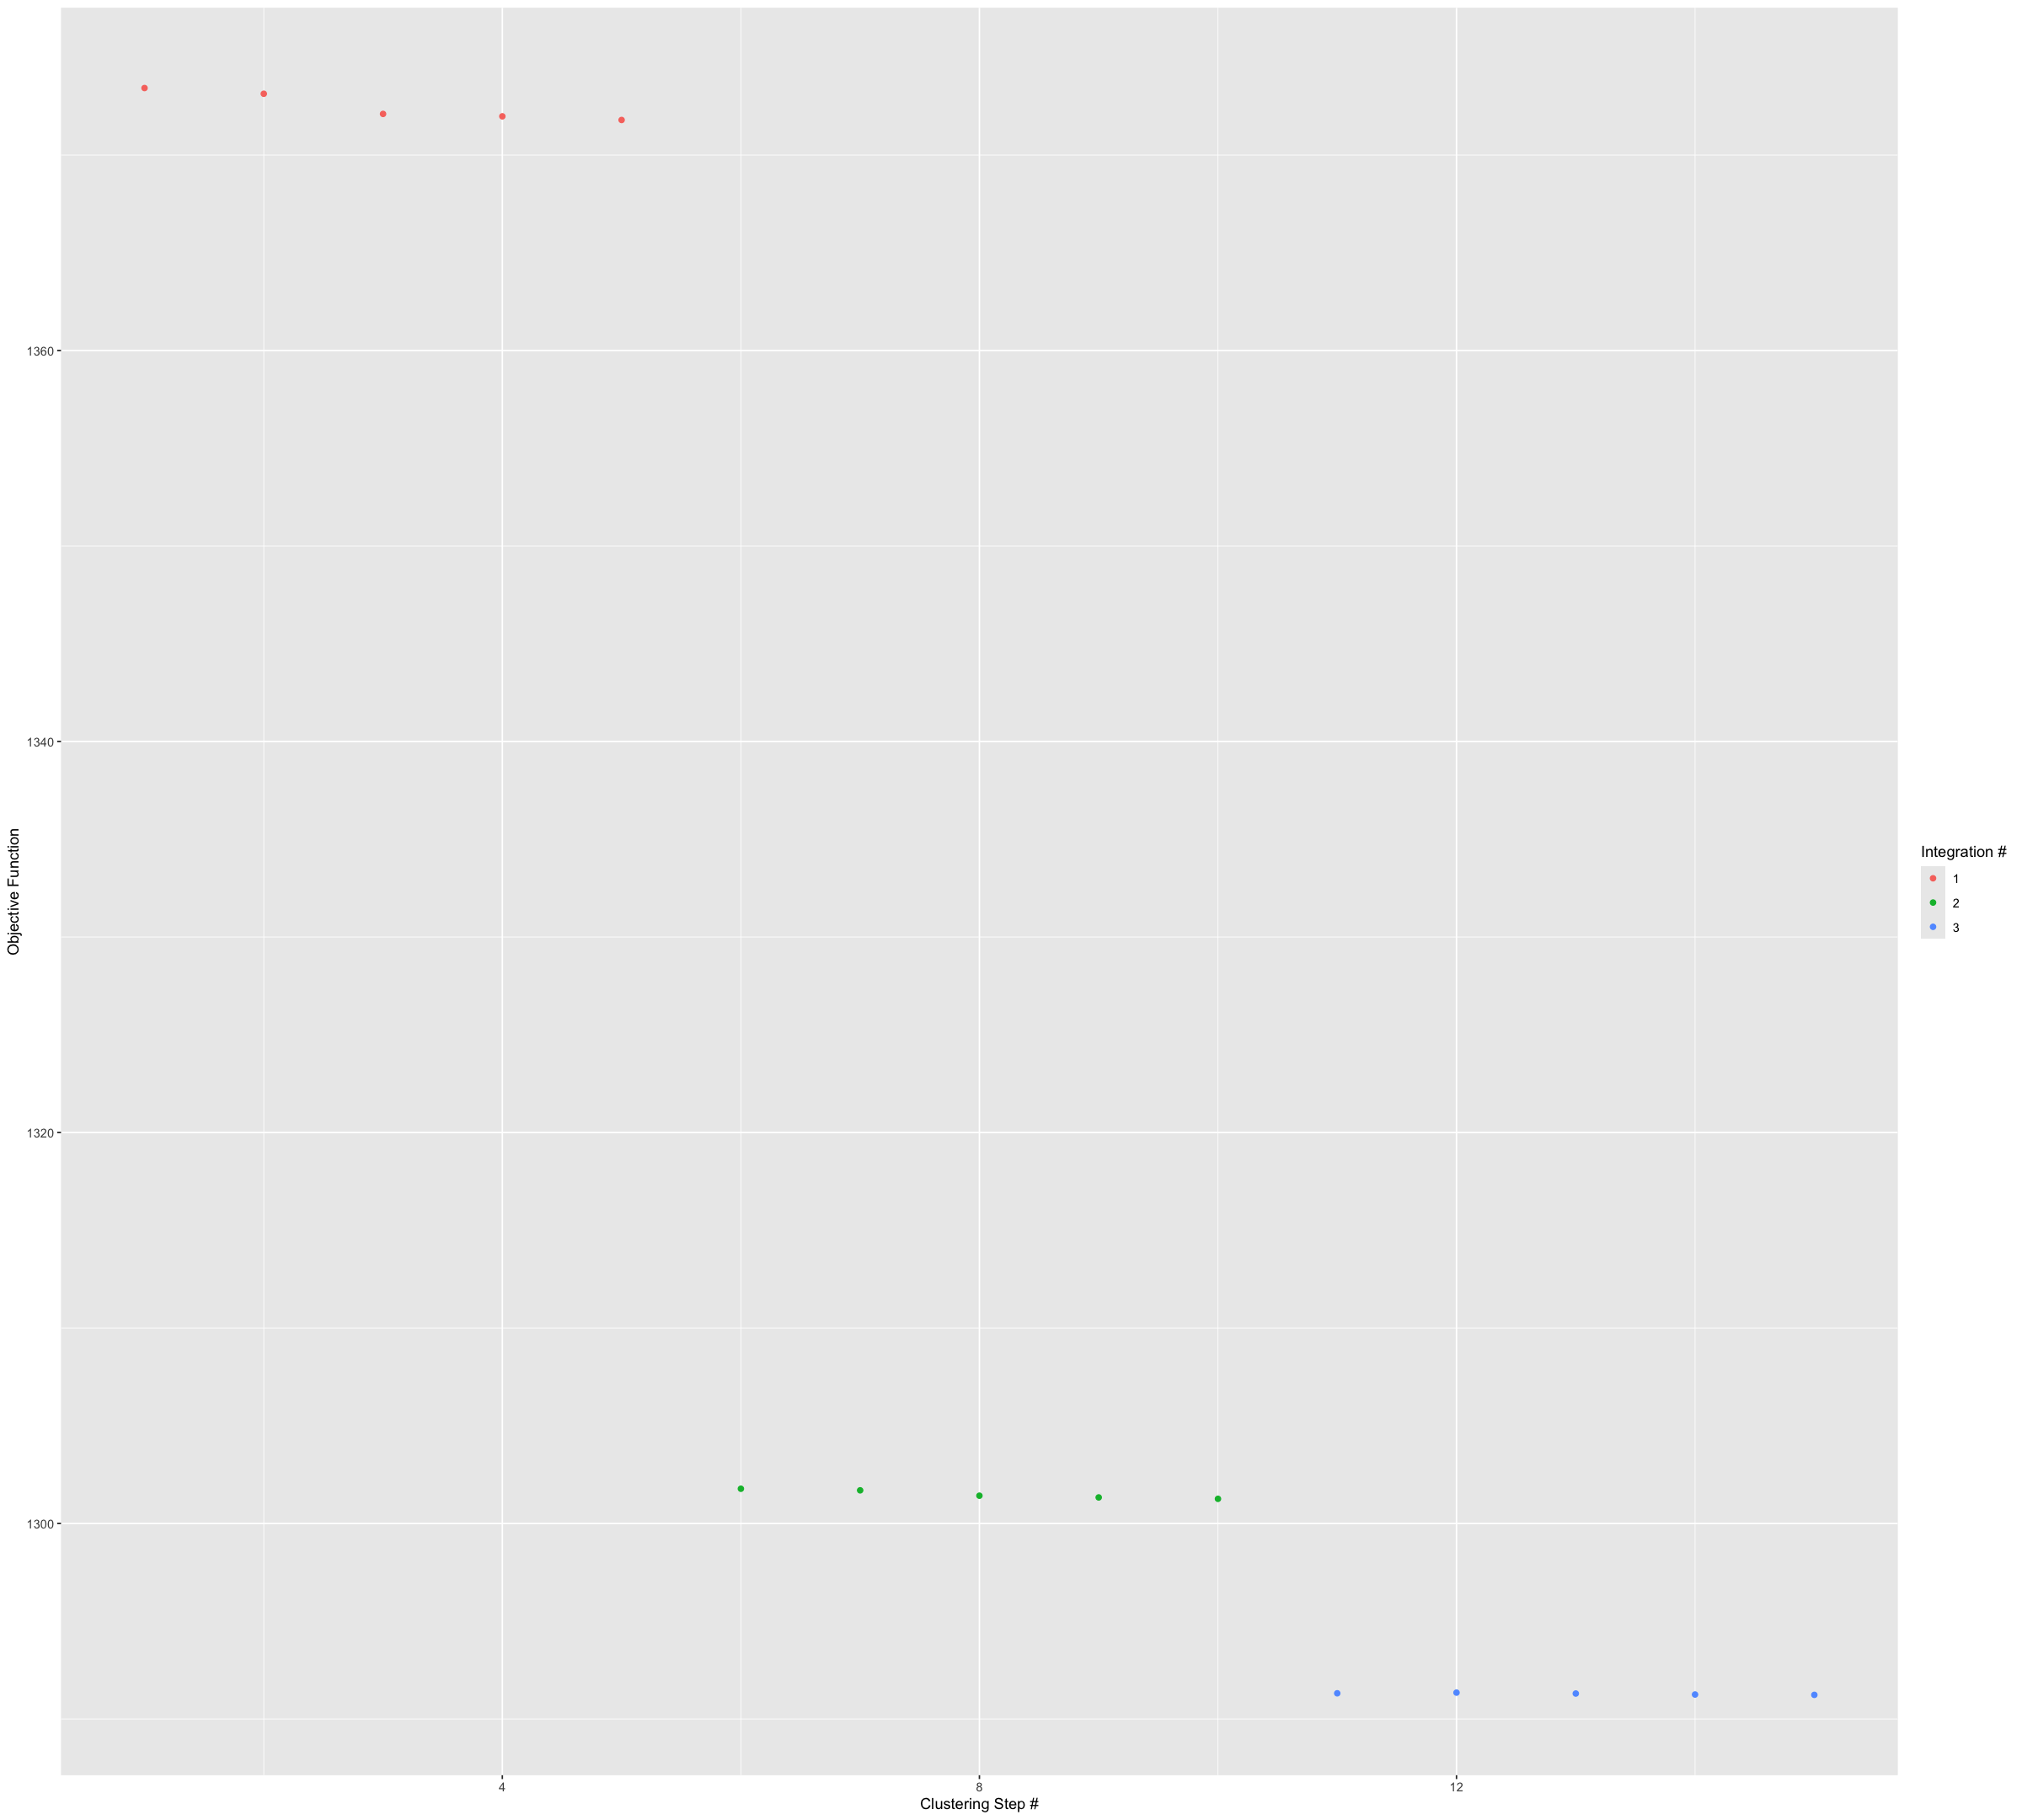

In [176]:
# harmonize NAM PC embeddings
library(harmony)
# used the "sample_id" column since this includes the visit as well, e.g., SUB_8_V1
# (subject id does not include visit information (SUB_8))
harmonized_NAMPC_embeddings <- RunHarmony(NAMPC_embeddings, dummy_data, 'sample_id', verbose=FALSE, theta = 4,
  max_iter = 10, plot_convergence = TRUE)
#colnames(harmonized_NAMPC_embeddings) <- paste0("PC", 1:ncol(pcs_matrix))
colnames(harmonized_NAMPC_embeddings) <- colnames(NAMPC_embeddings)
head(harmonized_NAMPC_embeddings)